In [48]:
%run 'data_preparation.ipynb'

In [19]:
from fbprophet import Prophet

In [86]:
year.tail()

,BOOKING_HAL_ID,CATEGORY_HAL_ID,VEHICLE_HAL_ID,CUSTOMER_HAL_ID,DATE_BOOKING,DATE_FROM,DATE_UNTIL,COMPUTE_EXTRA_BOOKING_FEE,TRAVERSE_USE,DISTANCE,...,BOOKING_DATE,FROM_DATE,BOOKING_YEAR,BOOKING_MONTH,BOOKING_WDAY,BOOKING_QUARTER,FROM_MONTH,UNTIL_MONTH,FROM_WDAY,UNTIL_WDAY
542932,43060293,100005,161830,FBFBE66F79A8407BF2DA061EB035A9E3BA60FB5C,2016-11-30 11:29:24,2016-11-30 09:05:46,2016-11-30 10:48:14,Nein,Nein,26,...,2016-11-30,2016-11-30,2016,11,2,4,11,11,2,2
542933,43070512,100005,161830,FBFBE66F79A8407BF2DA061EB035A9E3BA60FB5C,2016-11-30 21:22:43,2016-11-30 19:04:47,2016-11-30 21:20:02,Nein,Nein,57,...,2016-11-30,2016-11-30,2016,11,2,4,11,11,2,2
542934,43079191,100005,161830,FBFBE66F79A8407BF2DA061EB035A9E3BA60FB5C,2016-12-01 11:53:11,2016-12-01 09:10:44,2016-12-01 11:31:47,Nein,Nein,36,...,2016-12-01,2016-12-01,2016,12,3,4,12,12,3,3
542935,43087847,100005,161830,FBFBE66F79A8407BF2DA061EB035A9E3BA60FB5C,2016-12-01 19:59:15,2016-12-01 18:11:49,2016-12-01 19:58:13,Nein,Nein,34,...,2016-12-01,2016-12-01,2016,12,3,4,12,12,3,3
542936,43097826,100005,161830,FBFBE66F79A8407BF2DA061EB035A9E3BA60FB5C,2016-12-02 11:02:44,2016-12-02 09:06:58,2016-12-02 11:01:21,Nein,Nein,18,...,2016-12-02,2016-12-02,2016,12,4,4,12,12,4,4


In [87]:
per_day = year.pivot_table(index=['BOOKING_DATE'],values=['BOOKING_HAL_ID'], aggfunc=lambda x: len(x.unique()))

In [88]:
per_day.reset_index(inplace=True)
per_day.tail()

,BOOKING_DATE,BOOKING_HAL_ID
1091,2016-12-27,273
1092,2016-12-28,263
1093,2016-12-29,301
1094,2016-12-30,315
1095,2016-12-31,225


# Prediction with out holiday data

In [89]:
# Prophet requires columns ds (Date) and y (value)
per_day = per_day.rename(columns={'BOOKING_DATE': 'ds', 'BOOKING_HAL_ID': 'y'})
# Put market cap in billions
#per_day['y'] = per_day['y'] / 1e9
# Make the prophet model and fit on the data
per_day_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
per_day_prophet.fit(per_day)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [90]:
# Make a future dataframe for 2 years
per_day_forecast = per_day_prophet.make_future_dataframe(periods=24, freq='M')
# Make predictions
per_day_forecast = per_day_prophet.predict(per_day_forecast)

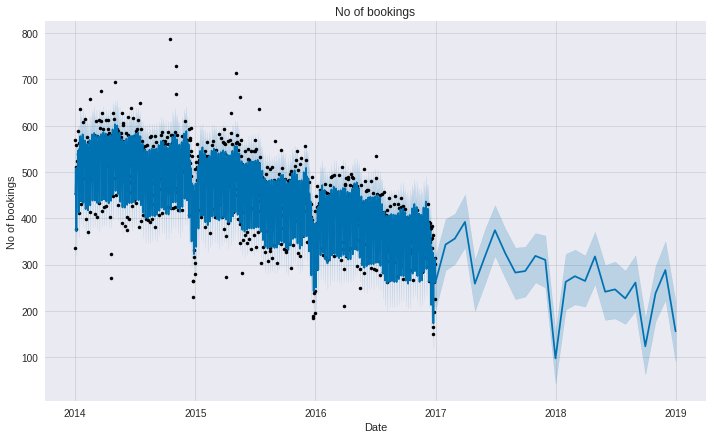

In [ ]:
per_day_prophet.plot(per_day_forecast, xlabel = 'Date', ylabel = 'No of bookings')
plt.title('No of bookings');

In [ ]:
per_day_prophet.plot_components(per_day_forecast);

# Prediction with holiday data

In [ ]:
promotions = pd.DataFrame({
  'holiday': holidays.PUBLIC_HOLIDAYS,
  'ds': holidays.BOOKING_DATE,
  'lower_window': 0,
  'upper_window': 0,
})

In [ ]:
promotions.head()

In [ ]:
model = Prophet(holidays=promotions)

In [ ]:
model.fit(per_day)

In [ ]:
future = model.make_future_dataframe(periods=24, freq = 'm')
future.tail()

In [ ]:
forecast = model.predict(future)

In [ ]:
model.plot(forecast);

In [ ]:
model.plot_components(forecast);

# Difference between holiday and non-holiday

In [ ]:
forecast.head()

In [ ]:
forecast.set_index('ds', inplace=True)
per_day_forecast.set_index('ds', inplace=True)
compared_df = forecast.join(per_day_forecast, rsuffix="_no_holiday")

In [ ]:
compared_df= np.exp(compared_df[['yhat', 'yhat_no_holiday']])

In [ ]:
compared_df['diff_per'] = 100*(compared_df['yhat'] - compared_df['yhat_no_holiday']) / compared_df['yhat_no_holiday']
compared_df.tail()

In [ ]:
compared_df['diff_per'].mean()

# Effect of Changepoint Prior Scale

In [ ]:
# Try 4 different changepoints
for changepoint in [0.001, 0.05, 0.1, 0.5]:
    model = fbprophet.Prophet(daily_seasonality=False, changepoint_prior_scale=changepoint)
    model.fit(per_day)
    
    future = model.make_future_dataframe(periods=12, freq='M')
    future = model.predict(future)
    
    per_day[changepoint] = future['yhat']

In [ ]:
plt.figure(figsize=(10, 8))

# Actual observations
plt.plot(per_day['ds'], per_day['y'], 'ko', label = 'Observations')
colors = {0.001: 'b', 0.05: 'r', 0.1: 'green', 0.5: 'gold'}

# Plot each of the changepoint predictions
for changepoint in [0.001, 0.05, 0.1, 0.5]:
    plt.plot(per_day['ds'], per_day[changepoint], color = colors[changepoint], label = '%.3f prior scale' % changepoint)
    
plt.legend(prop={'size': 14})
plt.xlabel('Date'); plt.ylabel('Number of bookings'); plt.title('Effect of Changepoint Prior Scale');
